In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Zrimec2020c

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-zrimec2020c'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-value.json'),
	to_numpy = True
)

tpm_level = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-level.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : 14071994,
	'batch_size'  : [64, 64, 64], # train, valid, eval
	'split_size'  : [60, 20, 20], # train, valid, eval
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'values' : 8
	}
}

config['split_size'] = [x / 100 for x in config['split_size']]

In [7]:
# Lock random

cnn_core.lock_random(seed = config['random_seed'])

## 2.1 Data

In [8]:
# Get the correct output group

targets = {
	key : numpy.array(value[config['output']['group1']], dtype = numpy.int64)
	for key, value in tpm_level.items()
}

In [9]:
# Update number of classes

classes = set(numpy.array([x for x in targets.values()]).flatten())

print(f'Classes Length : {len(classes)}')
print(f'Classes Unique : ' + ', '.join(str(x) for x in classes))

config['output']['classes'] = len(classes)

Classes Length : 5
Classes Unique : 0, 1, 2, 3, 4


In [10]:
# Create a <gene> dataset and split it into dataloaders

# expand_dims = None -> [batch_size, H, W]
# expand_dims =   -1 -> [batch_size, H, W]
# expand_dims =    0 -> [batch_size, 1, H, W]
# expand_dims =    1 -> [batch_size, H, 1, W]
# expand_dims =    2 -> [batch_size, H, W, 1]

dataloaders = GeneDataset(
	sequences   = gene_sequences,
	features    = gene_frequency,
	targets     = targets,
	expand_dims = None
).split_to_dataloader(
	split_size  = config['split_size'],
	batch_size  = config['batch_size'],
	random_seed = config['random_seed'],
	shuffle     = True,
	drop_last   = True
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [11]:
# Display the training dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size'][0]
)

Dataloader  batch  size :     64
Dataloader  batch count :    297
Dataloader sample count : 19,008

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [12]:
# Display the validation dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size'][1]
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [13]:
# Display the testing dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size'][2]
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

In [14]:
# Create and display the model structure

model = Zrimec2020c(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.25
	},
	'conv1' : {
		'filters' : 32,
		'kernel'  : 3,
		'padding' : 0
	},
	'conv2' : {
		'filters' : 64,
		'kernel'  : 9,
		'padding' : 4
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 9,
		'padding' : 4
	},
	'maxpool1' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool3' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'fc1' : {
		'features' : 128
	},
	'fc2' : {
		'features' : config['output']['classes'],
		'heads' : config['output']['values']
	}
})

model.summary(
	batch_size  = config['batch_size'][0],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [64, 4, 2150]             [64, 5, 8]                --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 128]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 32, 2148]            416
│    └─ReLU: 2-2                         [64, 32, 2148]            [64, 32, 2148]            --
│    └─BatchNorm1d: 2-3                  [64, 32, 2148]            [64, 32, 2148]            64
│    └─Dropout: 2-4                      [64, 32, 2148]            [64, 32, 2148]            --
│    └─MaxPool1d: 2-5                    [64, 32, 2148]            [64, 32, 430]             --
│    └─Conv1d: 2-6                       [64, 32, 430]             [64, 64, 430]             18,496
│    └─ReLU: 2-7                         [64, 64, 430]             [64, 64, 430]             --
│    └─BatchNorm1d: 2-8       

In [15]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

In [16]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'entropy',
	reduction = 'mean'
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 1e-4,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 2,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'), # None if should not save
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'), # None if should not save
	'epochs'    : 100,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		key : cnn_model.get_criterion(query = key, reduction = 'none')
		for key in ['entropy', 'acc']
	}
}

## 2.3 Training

In [17]:
# Train and validate the model

report = cnn_model.train_classifier(
	model  = model,
	params = params
)

In [18]:
# Display the training and validation loss per epoch

epochs = len(report['train']['loss'])

for epoch in range(epochs) :
	print(f'Epoch {(1 + epoch):03d} :', end = ' ')
	print('{:10.5f}'.format(report['train']['loss'][epoch]), end = ' ')
	print('{:10.5f}'.format(report['valid']['loss'][epoch]))

Epoch 001 :    1.70200    1.60878
Epoch 002 :    1.58954    1.58050
Epoch 003 :    1.55995    1.56940
Epoch 004 :    1.53793    1.54819
Epoch 005 :    1.51876    1.51505
Epoch 006 :    1.49804    1.49868
Epoch 007 :    1.48471    1.49018
Epoch 008 :    1.47237    1.47633
Epoch 009 :    1.46489    1.47084
Epoch 010 :    1.45656    1.47928
Epoch 011 :    1.45202    1.48917
Epoch 012 :    1.44677    1.46186
Epoch 013 :    1.44131    1.45614
Epoch 014 :    1.43434    1.46737
Epoch 015 :    1.43223    1.46390
Epoch 016 :    1.42562    1.46414
Epoch 017 :    1.41401    1.46295
Epoch 018 :    1.40598    1.46156
Epoch 019 :    1.40279    1.46830
Epoch 020 :    1.39182    1.46449
Epoch 021 :    1.38664    1.46406
Epoch 022 :    1.38261    1.46459
Epoch 023 :    1.37547    1.46266
Epoch 024 :    1.37477    1.46519
Epoch 025 :    1.37089    1.46439
Epoch 026 :    1.36608    1.46471
Epoch 027 :    1.36715    1.46509
Epoch 028 :    1.36176    1.46732
Epoch 029 :    1.36352    1.46506
Epoch 030 :   

### 2.3.1 Plots

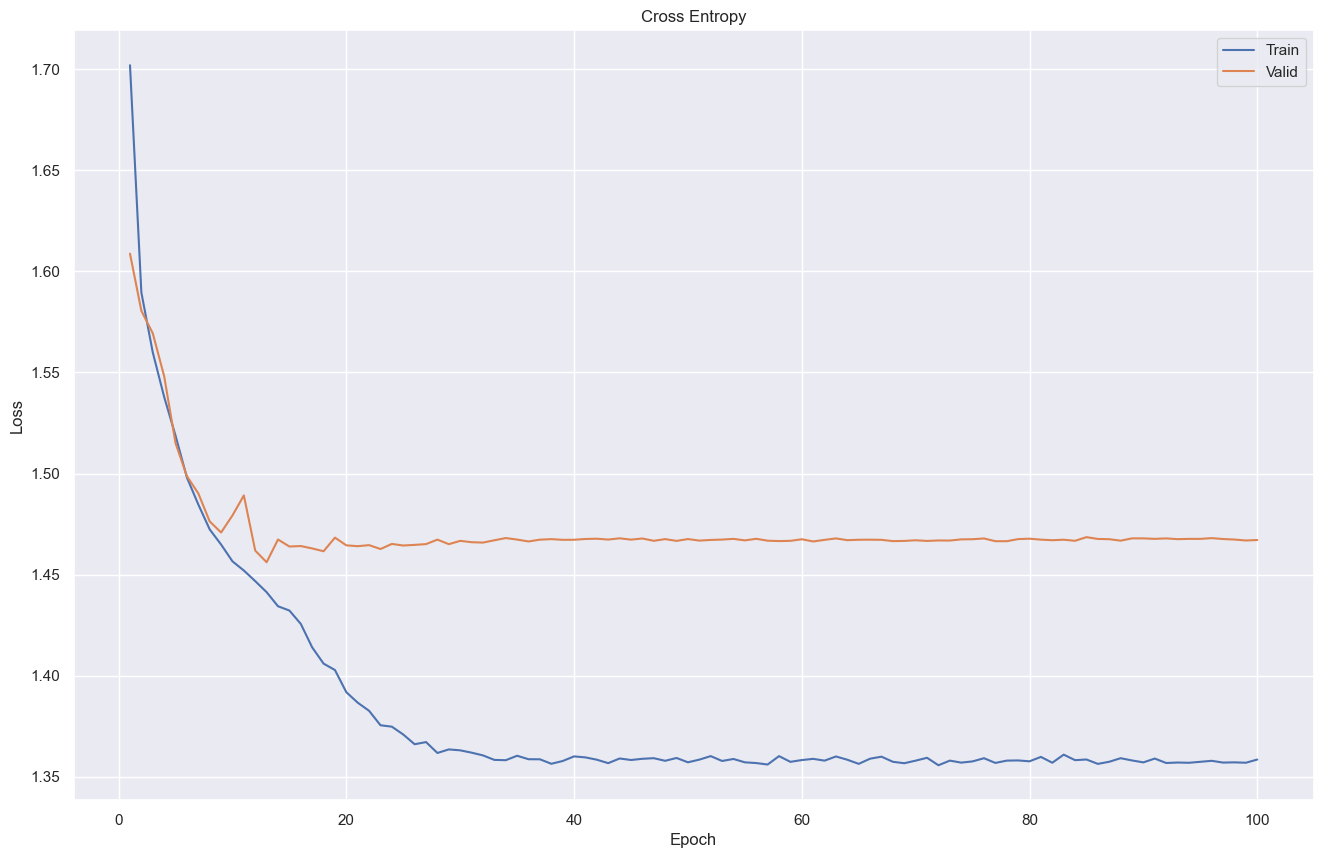

In [19]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Cross Entropy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

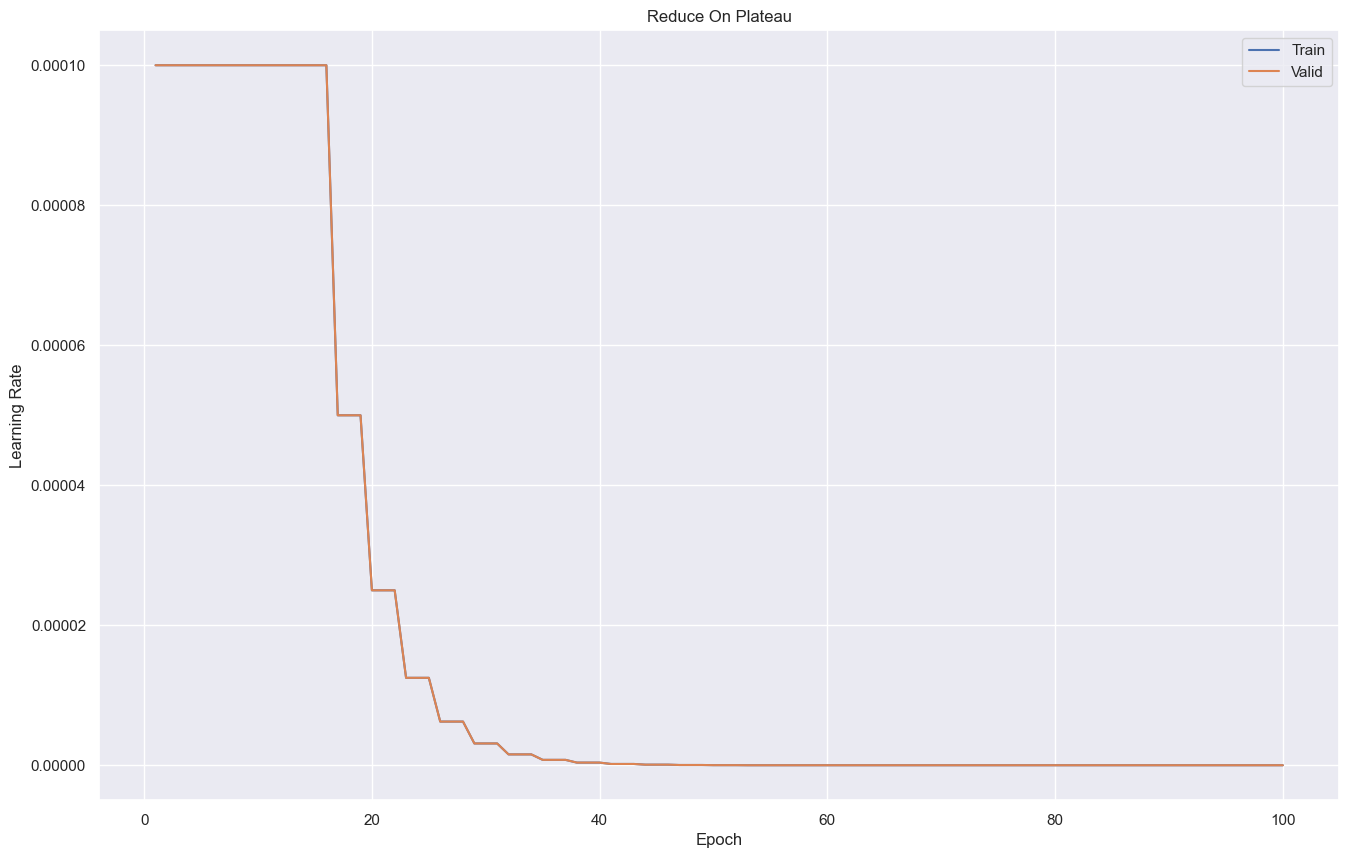

In [20]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

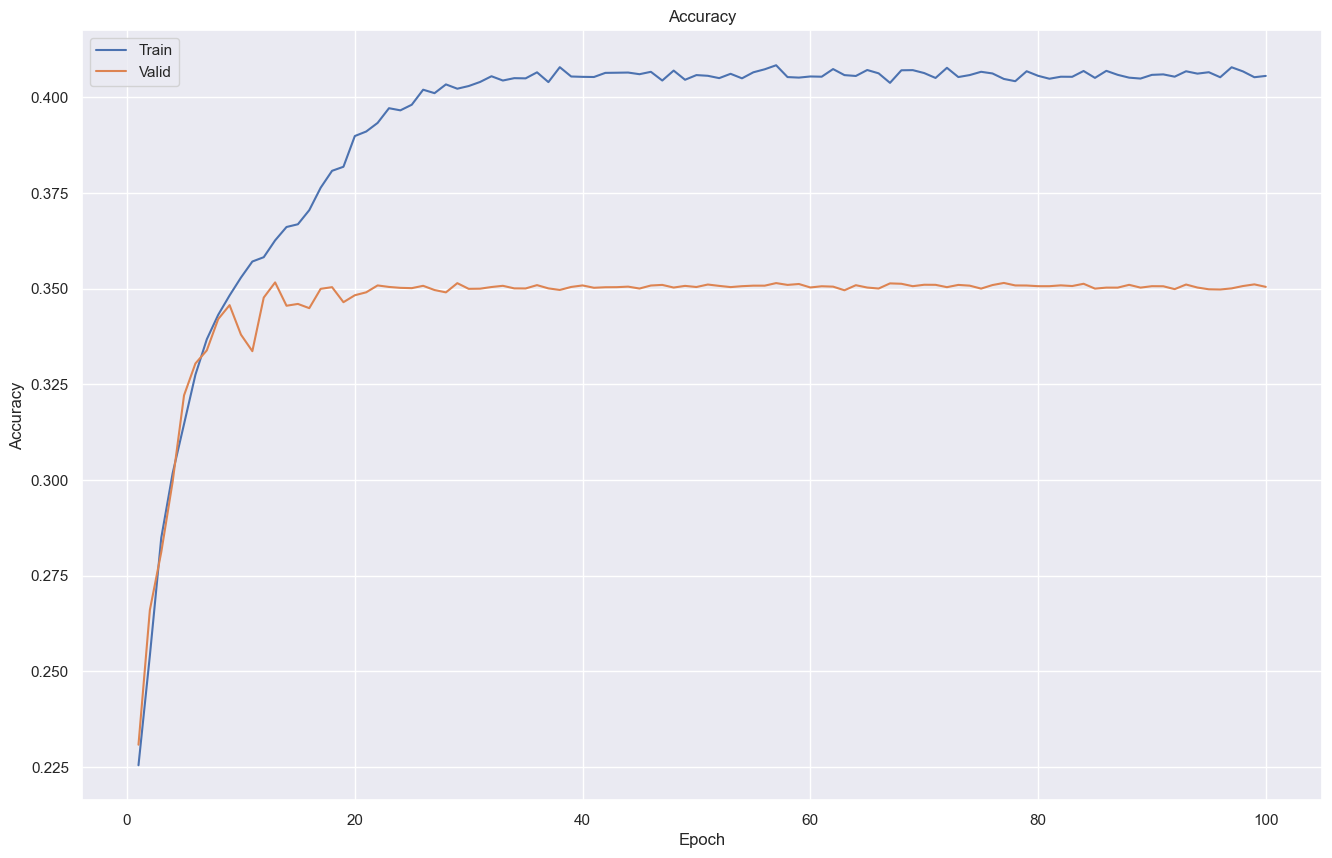

In [21]:
# Display the training and validation learning rate curves

cnn_plot.show_accuracy(
	report   = report,
	title    = 'Accuracy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

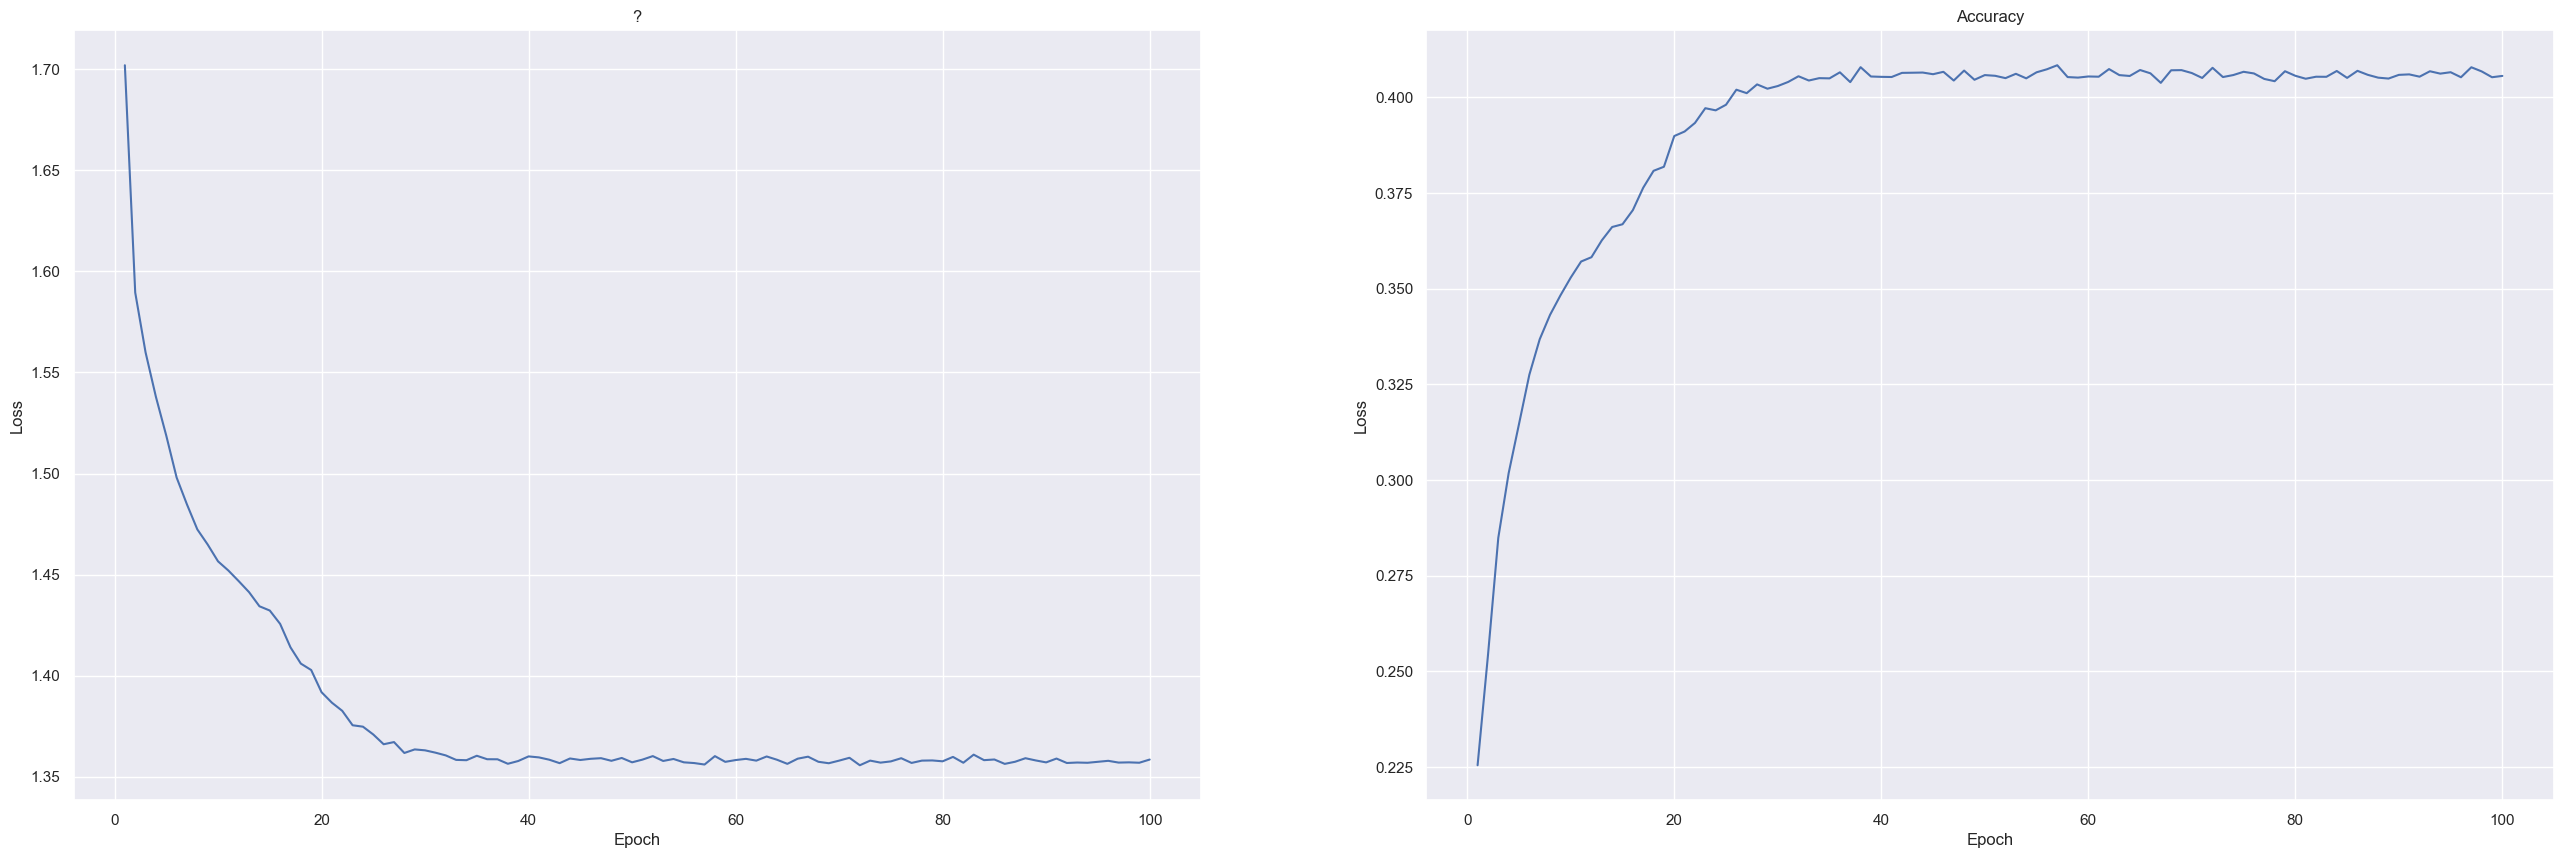

In [22]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

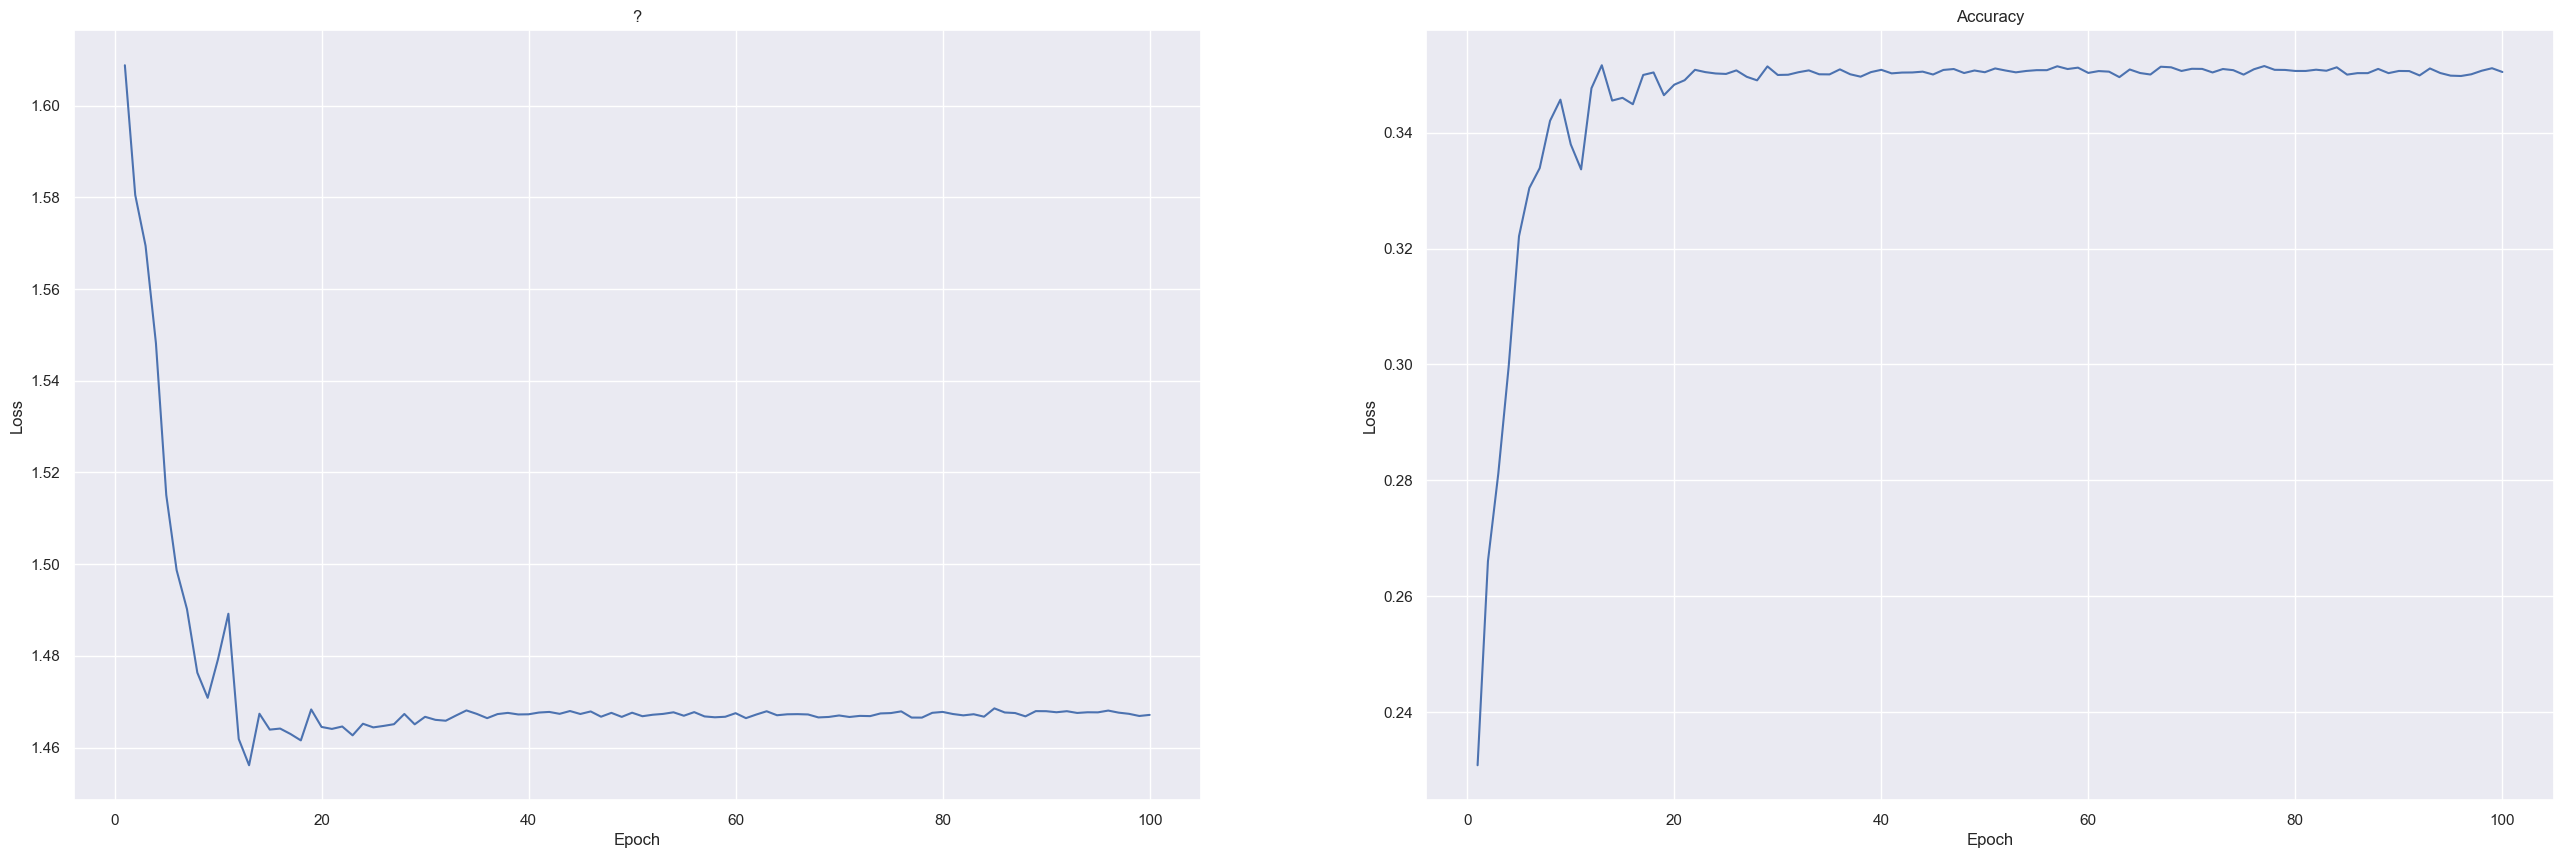

In [23]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [24]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 100
 Loss : 1.46712


<All keys matched successfully>

In [25]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

In [26]:
# Print the evaluation metrics

print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))
print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['acc'].mean()))

Entropy  :  1.45320
Accuracy :  0.35531


In [27]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene : AT2G41900.1
True : [4 4 4 4 4 4 4 1]
Pred : [2 1 1 1 1 1 0 0]
 CCE : [2.14578   2.79335   3.00322   2.36614   2.69643   2.59725   3.26106   1.36878]
 ACC : [0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000]

Gene : AT4G10490.1
True : [0 0 1 0 2 0 0 0]
Pred : [0 0 0 0 0 0 0 0]
 CCE : [0.96689   0.40561   1.42060   0.80377   2.01611   0.83031   0.34543   0.36602]
 ACC : [1.00000   1.00000   0.00000   1.00000   0.00000   1.00000   1.00000   1.00000]



In [28]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report['eval'],
	order  = tpm_order[config['output']['group0']]
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 35.53109 %
Average Missed 1 : 32.41596 %
Average Missed 2 : 17.98059 %
Average Missed 3 : 10.01223 %
Average Missed 4 :  4.06013 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
7,senescence_reproductive,6336,41.49,34.11,17.50,6.19,0.71
0,flower,6336,38.68,29.26,17.53,9.25,5.27
3,root,6336,36.19,27.98,18.54,10.57,6.71
4,seed,6336,34.63,32.37,18.28,10.73,3.99
5,seedling,6336,34.34,31.38,18.36,11.81,4.12
1,leaf,6336,34.00,28.80,17.53,12.66,7.01
6,senescence_green,6336,33.49,33.95,17.66,11.65,3.25
2,other,6336,31.42,41.48,18.43,7.24,1.42


### 2.4.2 Best Model

In [29]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 13
 Loss : 1.45614


<All keys matched successfully>

In [30]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

In [31]:
# Print the evaluation metrics

print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))
print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['acc'].mean()))

Entropy  :  1.44510
Accuracy :  0.35642


In [32]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene : AT5G28830.1
True : [3 3 3 4 3 3 3 2]
Pred : [4 4 3 4 4 4 0 0]
 CCE : [1.56926   1.61779   1.35437   0.99677   1.57786   1.47341   1.51862   1.67094]
 ACC : [0.00000   0.00000   1.00000   1.00000   0.00000   0.00000   0.00000   0.00000]

Gene : AT5G50760.1
True : [0 1 0 4 1 3 1 0]
Pred : [4 0 3 4 1 3 0 0]
 CCE : [2.08781   1.60720   1.79817   1.34766   1.51641   1.49059   1.56873   0.85740]
 ACC : [0.00000   0.00000   0.00000   1.00000   1.00000   1.00000   0.00000   1.00000]



In [33]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report['eval'],
	order  = tpm_order[config['output']['group0']]
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 35.64157 %
Average Missed 1 : 31.77281 %
Average Missed 2 : 18.01413 %
Average Missed 3 : 10.09706 %
Average Missed 4 :  4.47443 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
7,senescence_reproductive,6336,41.79,33.11,18.15,6.09,0.85
0,flower,6336,38.37,27.64,17.58,10.46,5.95
3,root,6336,35.91,27.43,18.88,10.27,7.51
5,seedling,6336,35.05,29.39,18.04,12.28,5.24
4,seed,6336,34.97,30.73,17.93,11.57,4.80
1,leaf,6336,33.82,29.36,17.38,12.09,7.35
6,senescence_green,6336,33.78,34.42,18.02,10.80,2.98
2,other,6336,31.44,42.11,18.13,7.21,1.10


## 2.5 Visualization